In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 100]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 100)   y shape:  (4383, 1)
train1 X: (3618, 100)  train1 y: (3618, 1)  Test1 X shape: (365, 100)  Test1 y shape: (365, 1)
validation1 X: (400, 100)  validation1 y: (400, 1)
train2 X: (3293, 100)  train2 y: (3293, 1)  Test2 X: (365, 100)  Test2 y: (365, 1)
validation2 X: (360, 100)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[9]

((100, 1), (100,), ('flu',), ('cough after flu',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,100):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  56


In [10]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
def eNet(a,l,train_X,train_y,test_X,test_y):
    
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    

# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [11]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 56) (400, 56)


((4018, 56), (4018, 1))

In [12]:
## Fixing l1-ratio = 0.3, only tuning alpha.
para = np.arange(0.01, 2.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train1_X1,train1_y,val1_X1,val1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 48 from 56
Best RMSE is updated! 
The mean absolute error is:  18.291623918780978
The root mean squared error is:  32.701129544256986
The correlation is:  0.9258314101040822
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 43 from 56
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 40 from 56
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 37 from 56
alpha: 0.05  L1-ratio: 0.3
Nonzero weights: 35 from 56
alpha: 0.060000000000000005  L1-ratio: 0.3
Nonzero weights: 33 from 56
alpha: 0.06999999999999999  L1-ratio: 0.3
Nonzero weights: 30 from 56
alpha: 0.08  L1-ratio: 0.3
Nonzero weights: 30 from 56
alpha: 0.09  L1-ratio: 0.3
Nonzero weights: 29 from 56
alpha: 0.09999999999999999  L1-ratio: 0.3
Nonzero weights: 28 from 56
alpha: 0.11  L1-ratio: 0.3
Nonzero weights: 26 from 56
alpha: 0.12  L1-ratio: 0.3
Nonzero weights: 24 from 56
Best RMSE is updated! 
The mean a

Nonzero weights: 15 from 56
Best RMSE is updated! 
The mean absolute error is:  13.272605316872877
The root mean squared error is:  22.32731162473641
The correlation is:  0.8649801050988343
----------------------------------------
alpha: 0.43  L1-ratio: 0.3
Nonzero weights: 15 from 56
Best RMSE is updated! 
The mean absolute error is:  13.18413770357598
The root mean squared error is:  22.157422421504005
The correlation is:  0.8646072580294729
----------------------------------------
alpha: 0.44  L1-ratio: 0.3
Nonzero weights: 15 from 56
Best RMSE is updated! 
The mean absolute error is:  13.095813121588565
The root mean squared error is:  21.988583309056118
The correlation is:  0.8642426708111487
----------------------------------------
alpha: 0.45  L1-ratio: 0.3
Nonzero weights: 15 from 56
Best RMSE is updated! 
The mean absolute error is:  13.007637281289487
The root mean squared error is:  21.820818303618456
The correlation is:  0.8638859702048421
----------------------------------

Nonzero weights: 8 from 56
Best RMSE is updated! 
The mean absolute error is:  9.81842251278121
The root mean squared error is:  15.651841606306723
The correlation is:  0.8589954981912403
----------------------------------------
alpha: 0.8400000000000001  L1-ratio: 0.3
Nonzero weights: 8 from 56
Best RMSE is updated! 
The mean absolute error is:  9.742999631995204
The root mean squared error is:  15.522452455850756
The correlation is:  0.8590017063702006
----------------------------------------
alpha: 0.85  L1-ratio: 0.3
Nonzero weights: 8 from 56
Best RMSE is updated! 
The mean absolute error is:  9.67003192303175
The root mean squared error is:  15.39604462421408
The correlation is:  0.8590102267938737
----------------------------------------
alpha: 0.86  L1-ratio: 0.3
Nonzero weights: 8 from 56
Best RMSE is updated! 
The mean absolute error is:  9.602512301287112
The root mean squared error is:  15.272611060364785
The correlation is:  0.8590219306092179
-----------------------------

alpha: 1.31  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.32  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.33  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.34  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.35  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.36  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.37  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.3800000000000001  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.3900000000000001  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.4000000000000001  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.4100000000000001  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.42  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.43  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.44  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.45  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.46  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.47  L1-ratio: 0.3
Nonzero weights: 5 from 56
alpha: 1.48  L1-ratio: 0.3

In [13]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [1.21]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 1.21  L1-ratio: 0.3
Nonzero weights: 10 from 56
Best RMSE is updated! 
The mean absolute error is:  4.791602896499729
The root mean squared error is:  5.36885724970752
The correlation is:  0.7106393325355076
----------------------------------------


In [20]:

para = np.arange(40000, 1000000, 1000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 40000
Best RMSE is updated! 
The mean absolute error is:  8.581576577362485
The root mean squared error is:  15.69060670957531
The correlation is:  0.798702496199972
----------------------------------------
alpha: 41000
Best RMSE is updated! 
The mean absolute error is:  8.582246290718054
The root mean squared error is:  15.654698842641624
The correlation is:  0.7985495717833241
----------------------------------------
alpha: 42000
Best RMSE is updated! 
The mean absolute error is:  8.589197132597286
The root mean squared error is:  15.624693488885184
The correlation is:  0.7984032650931006
----------------------------------------
alpha: 43000
Best RMSE is updated! 
The mean absolute error is:  8.599504255112677
The root mean squared error is:  15.600236174073103
The correlation is:  0.7982631541628737
----------------------------------------
alpha: 44000
Best RMSE is updated! 
The mean absolute error is:  8.612471283271057
The root mean squared error is:  15.580991738769262
The

alpha: 490000
alpha: 491000
alpha: 492000
alpha: 493000
alpha: 494000
alpha: 495000
alpha: 496000
alpha: 497000
alpha: 498000
alpha: 499000
alpha: 500000
alpha: 501000
alpha: 502000
alpha: 503000
alpha: 504000
alpha: 505000
alpha: 506000
alpha: 507000
alpha: 508000
alpha: 509000
alpha: 510000
alpha: 511000
alpha: 512000
alpha: 513000
alpha: 514000
alpha: 515000
alpha: 516000
alpha: 517000
alpha: 518000
alpha: 519000
alpha: 520000
alpha: 521000
alpha: 522000
alpha: 523000
alpha: 524000
alpha: 525000
alpha: 526000
alpha: 527000
alpha: 528000
alpha: 529000
alpha: 530000
alpha: 531000
alpha: 532000
alpha: 533000
alpha: 534000
alpha: 535000
alpha: 536000
alpha: 537000
alpha: 538000
alpha: 539000
alpha: 540000
alpha: 541000
alpha: 542000
alpha: 543000
alpha: 544000
alpha: 545000
alpha: 546000
alpha: 547000
alpha: 548000
alpha: 549000
alpha: 550000
alpha: 551000
alpha: 552000
alpha: 553000
alpha: 554000
alpha: 555000
alpha: 556000
alpha: 557000
alpha: 558000
alpha: 559000
alpha: 560000
alpha:

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [21]:
para =[48000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 48000
Best RMSE is updated! 
The mean absolute error is:  4.614080401419742
The root mean squared error is:  5.048293587376063
The correlation is:  0.7610413350004049
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  3.1149638517788856
The root mean squared error is:  3.728084972863996
The correlation is:  0.9100691382953876
----------------------------------------


In [22]:
alpha=48000
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

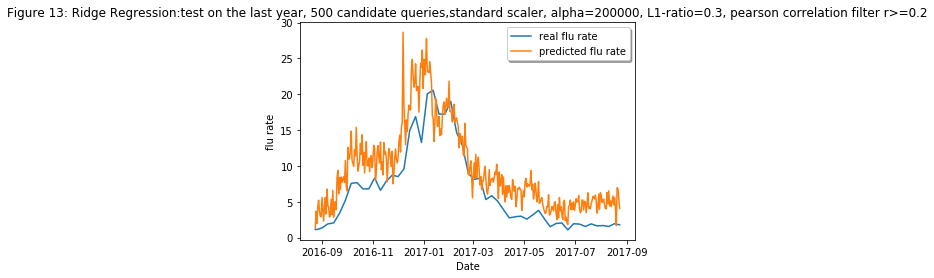

In [23]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 13: Ridge Regression:test on the last year, 500 candidate queries,standard scaler, alpha=200000, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

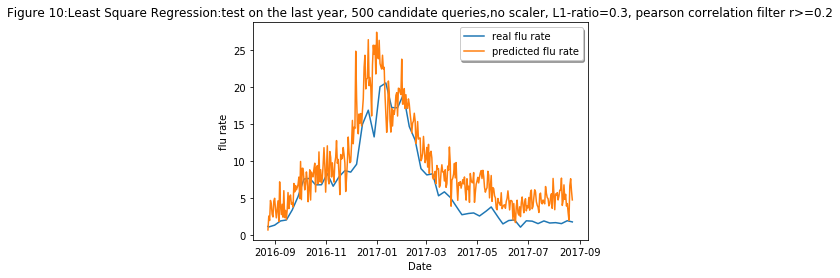

In [14]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 10:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [26]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[9]

((100, 1), (100,), ('flu',), ('cough after flu',))

In [27]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [28]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  65


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [29]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 65) (360, 65)


((3653, 65), (3653, 1))

In [32]:
para = np.arange(0.01, 20.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.1, 303 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 56 from 65
Best RMSE is updated! 
The mean absolute error is:  4.0044212492277875
The root mean squared error is:  6.5010327911957795
The correlation is:  0.5684166736935224
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 47 from 65
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 44 from 65
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 38 from 65
alpha: 0.05  L1-ratio: 0.3
Nonzero weights: 40 from 65
alpha: 0.060000000000000005  L1-ratio: 0.3
Nonzero weights: 36 from 65
alpha: 0.06999999999999999  L1-ratio: 0.3
Nonzero weights: 36 from 65
alpha: 0.08  L1-ratio: 0.3
Nonzero weights: 35 from 65
alpha: 0.09  L1-ratio: 0.3
Nonzero weights: 33 from 65
alpha: 0.09999999999999999  L1-ratio: 0.3
Nonzero weights: 33 from 65
alpha: 0.11  L1-ratio: 0.3
Nonzero weights: 31 from 65
alpha: 0.12  L1-ratio: 0.3
Nonzero weights: 29 from 65
alpha: 0.13  L1-ratio: 0.3
Nonzer

alpha: 1.3800000000000001  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.3900000000000001  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.4000000000000001  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.4100000000000001  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.42  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.43  L1-ratio: 0.3
Nonzero weights: 11 from 65
alpha: 1.44  L1-ratio: 0.3
Nonzero weights: 10 from 65
alpha: 1.45  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.46  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.47  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.48  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.49  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.5  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.51  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.52  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.53  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.54  L1-ratio: 0.3
Nonzero weights: 9 from 65
alpha: 1.55  L1-rati

Nonzero weights: 0 from 65
alpha: 3.06  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.07  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.08  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.09  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.0999999999999996  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.11  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.1199999999999997  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.13  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.1399999999999997  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.15  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.1599999999999997  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.17  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.1799999999999997  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.19  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.1999999999999997  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.21  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 3.2199999999999998

Nonzero weights: 0 from 65
alpha: 4.68  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.6899999999999995  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.7  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.71  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.72  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.7299999999999995  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.74  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.75  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.76  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.77  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.78  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.79  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.8  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.81  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.82  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.83  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.84  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 4.85  L1-ratio: 0.3
No

alpha: 6.37  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.38  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.39  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.4  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.41  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.42  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.43  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.4399999999999995  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.45  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.46  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.47  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.4799999999999995  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.49  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.5  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.51  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.52  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.53  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 6.54  L1-ratio: 0.3
Nonzero weights: 0 from 65
al

Nonzero weights: 0 from 65
alpha: 8.01  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.02  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.03  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.04  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.05  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.06  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.07  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.08  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.09  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.1  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.11  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.12  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.13  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.14  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.15  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.16  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.17  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 8.18  L1-ratio: 0.3
Nonzero weights: 0 from 65
al

Nonzero weights: 0 from 65
alpha: 9.55  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.56  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.57  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.58  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.59  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.6  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.61  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.62  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.63  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.64  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.65  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.66  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.67  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.68  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.69  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.7  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.71  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 9.72  L1-ratio: 0.3
Nonzero weights: 0 from 65
alp

Nonzero weights: 0 from 65
alpha: 11.24  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.25  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.26  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.27  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.28  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.29  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.3  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.31  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.32  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.33  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.34  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.35  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.36  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.37  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.38  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.39  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.4  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 11.41  L1-ratio: 0.3
Nonzero weig

Nonzero weights: 0 from 65
alpha: 12.78  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.790000000000001  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.8  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.81  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.82  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.83  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.84  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.85  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.86  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.87  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.88  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.89  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.9  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.91  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.92  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.93  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.94  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 12.95  L1-ratio: 0.3

Nonzero weights: 0 from 65
alpha: 14.4  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.41  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.42  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.43  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.44  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.45  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.46  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.47  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.48  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.49  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.5  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.51  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.52  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.53  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.540000000000001  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.55  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.56  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 14.57  L1-ratio: 0.3

Nonzero weights: 0 from 65
alpha: 16.080000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.090000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.1  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.110000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.12  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.130000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.14  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.150000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.16  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.17  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.180000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.19  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.200000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.21  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.220000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 16.23  L1-ratio: 0.3
Nonzero weights: 

Nonzero weights: 0 from 65
alpha: 17.48  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.490000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.500000000000004  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.51  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.520000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.53  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.540000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.55  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.560000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.57  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.580000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.590000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.6  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.610000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.62  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 17.630000000000003  L1-ratio: 0.3
Nonz

Nonzero weights: 0 from 65
alpha: 19.020000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.03  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.040000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.05  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.060000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.07  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.080000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.090000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.1  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.110000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.12  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.130000000000003  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.14  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.150000000000002  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.160000000000004  L1-ratio: 0.3
Nonzero weights: 0 from 65
alpha: 19.17  L1-ratio: 0.3
Nonz

In [33]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [0.01]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 222 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 222 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 57 from 65
Best RMSE is updated! 
The mean absolute error is:  3.047203709871383
The root mean squared error is:  3.7590069974646103
The correlation is:  0.8718185062723668
----------------------------------------


In [34]:

para =np.arange(1, 1000, 1)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 1
Best RMSE is updated! 
The mean absolute error is:  4.592114811300331
The root mean squared error is:  8.564763808129184
The correlation is:  0.40189917691482835
----------------------------------------
alpha: 2
Best RMSE is updated! 
The mean absolute error is:  4.525605130985476
The root mean squared error is:  8.334079503830106
The correlation is:  0.41578466863233704
----------------------------------------
alpha: 3
Best RMSE is updated! 
The mean absolute error is:  4.463633506339662
The root mean squared error is:  8.120692676368664
The correlation is:  0.42939124256822164
----------------------------------------
alpha: 4
Best RMSE is updated! 
The mean absolute error is:  4.405599293418914
The root mean squared error is:  7.9230761405314
The correlation is:  0.44270104820008
----------------------------------------
alpha: 5
Best RMSE is updated! 
The mean absolute error is:  4.350941031399104
The root mean squared error is:  7.73992833037423
The correlation is:  0.45569

alpha: 41
alpha: 42
alpha: 43
alpha: 44
alpha: 45
alpha: 46
alpha: 47
alpha: 48
alpha: 49
alpha: 50
alpha: 51
alpha: 52
alpha: 53
alpha: 54
alpha: 55
alpha: 56
alpha: 57
alpha: 58
alpha: 59
alpha: 60
alpha: 61
alpha: 62
alpha: 63
alpha: 64
alpha: 65
alpha: 66
alpha: 67
alpha: 68
alpha: 69
alpha: 70
alpha: 71
alpha: 72
alpha: 73
alpha: 74
alpha: 75
alpha: 76
alpha: 77
alpha: 78
alpha: 79
alpha: 80
alpha: 81
alpha: 82
alpha: 83
alpha: 84
alpha: 85
alpha: 86
alpha: 87
alpha: 88
alpha: 89
alpha: 90
alpha: 91
alpha: 92
alpha: 93
alpha: 94
alpha: 95
alpha: 96
alpha: 97
alpha: 98
alpha: 99
alpha: 100
alpha: 101
alpha: 102
alpha: 103
alpha: 104
alpha: 105
alpha: 106
alpha: 107
alpha: 108
alpha: 109
alpha: 110
alpha: 111
alpha: 112
alpha: 113
alpha: 114
alpha: 115
alpha: 116
alpha: 117
alpha: 118
alpha: 119
alpha: 120
alpha: 121
alpha: 122
alpha: 123
alpha: 124
alpha: 125
alpha: 126
alpha: 127
alpha: 128
alpha: 129
alpha: 130
alpha: 131
alpha: 132
alpha: 133
alpha: 134
alpha: 135
alpha: 136
alp

alpha: 816
alpha: 817
alpha: 818
alpha: 819
alpha: 820
alpha: 821
alpha: 822
alpha: 823
alpha: 824
alpha: 825
alpha: 826
alpha: 827
alpha: 828
alpha: 829
alpha: 830
alpha: 831
alpha: 832
alpha: 833
alpha: 834
alpha: 835
alpha: 836
alpha: 837
alpha: 838
alpha: 839
alpha: 840
alpha: 841
alpha: 842
alpha: 843
alpha: 844
alpha: 845
alpha: 846
alpha: 847
alpha: 848
alpha: 849
alpha: 850
alpha: 851
alpha: 852
alpha: 853
alpha: 854
alpha: 855
alpha: 856
alpha: 857
alpha: 858
alpha: 859
alpha: 860
alpha: 861
alpha: 862
alpha: 863
alpha: 864
alpha: 865
alpha: 866
alpha: 867
alpha: 868
alpha: 869
alpha: 870
alpha: 871
alpha: 872
alpha: 873
alpha: 874
alpha: 875
alpha: 876
alpha: 877
alpha: 878
alpha: 879
alpha: 880
alpha: 881
alpha: 882
alpha: 883
alpha: 884
alpha: 885
alpha: 886
alpha: 887
alpha: 888
alpha: 889
alpha: 890
alpha: 891
alpha: 892
alpha: 893
alpha: 894
alpha: 895
alpha: 896
alpha: 897
alpha: 898
alpha: 899
alpha: 900
alpha: 901
alpha: 902
alpha: 903
alpha: 904
alpha: 905
alpha: 906

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [35]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [34,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 34
Best RMSE is updated! 
The mean absolute error is:  2.92459405987687
The root mean squared error is:  3.6532094509457336
The correlation is:  0.8777898482776613
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.664707502350594
The root mean squared error is:  3.388036926639593
The correlation is:  0.8939781590666767
----------------------------------------


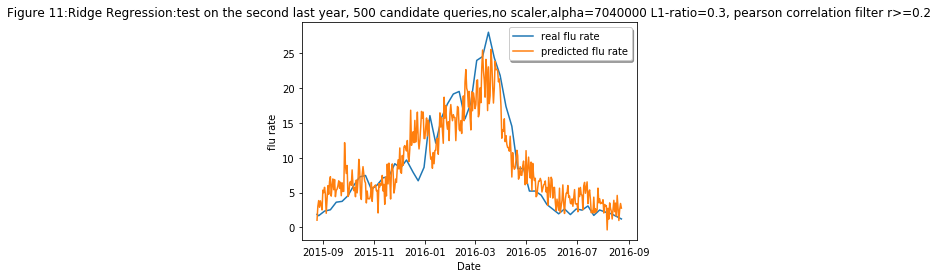

In [36]:
alpha=1
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 11:Ridge Regression:test on the second last year, 500 candidate queries,no scaler,alpha=7040000 L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

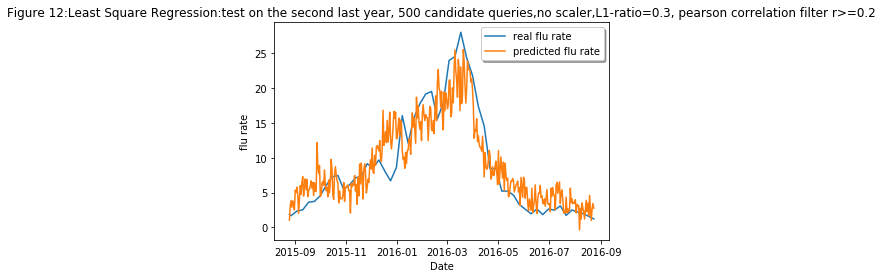

In [37]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 12:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()